In [207]:
using Flux, CUDA, OneHotArrays
using ProgressMeter
using Plots; plotlyjs()
using Random, Distributions
using CSV, DataFrames
using Images

In [370]:
# Data Preparation

rawDataFrame = CSV.read("DataCutP4.csv", DataFrame)
paramsNum = ncol(rawDataFrame)
xyRaw = Matrix(rawDataFrame)

function splitMatrix(mat, perc)
    @assert 0 <= perc <= 1
    ids = collect(axes(mat, 1))
    shuffle!(ids)
    sel = ids .<= size(mat, 1) .* perc
    return view(mat, sel, :), view(mat, .!sel, :)
end

xyTrain, xyTest = splitMatrix(xyRaw, 0.5)
xTrain, yTrain = xyTrain[:, 1:(paramsNum - 1)]', xyTrain[:, paramsNum]'
xTest, yTest = xyTest[:, 1:(paramsNum - 1)]', xyTest[:, paramsNum]'

([4.022553 35.875175 … 74.989075 4.7751775; 0.083023906 0.07815945 … 0.0 0.048176274; … ; 1.8260946 4.482917 … 0.3124904 3.7391012; 2.7926148 1.64822906 … 19.640076 1.9697854000000001], [0.0 0.0 … 1.0 1.0])

In [371]:
model = Flux.Chain(
    Flux.Dense((paramsNum - 1) => 256, rrelu),
    BatchNorm(256),
    Flux.Dense(256 => 128, hardtanh),
    BatchNorm(128),
    Flux.Dense(128 => 8, logcosh),
    BatchNorm(8),
    Flux.Dense(8 => 4, trelu),
    BatchNorm(4),
    Flux.Dense(4 => 1, relu6)
) |> gpu
# loss(x, y) = mean(abs.(model(x) .- y))
loss(x, y) = Flux.Losses.logitcrossentropy(model(x), y)
parameters = Flux.params(model)
learningRate = 0.05
optimiser = Descent(learningRate)

xTrain, yTrain = Float32.(xTrain) |> gpu, Float32.(yTrain) |> gpu
data = [(xTrain, yTrain)]

1-element Vector{Tuple{CuArray{Float32, 2, CUDA.DeviceMemory}, CuArray{Float32, 2, CUDA.DeviceMemory}}}:
 ([29.596455 44.927094 … 43.05546 17.376879; 0.0 0.15880251 … 0.072944626 0.24276319; … ; 3.6520216 3.443783 … -1.4528608 2.7890713; 3.187708 11.714671 … 0.37576306 0.9070453], [0.0 0.0 … 1.0 0.0])

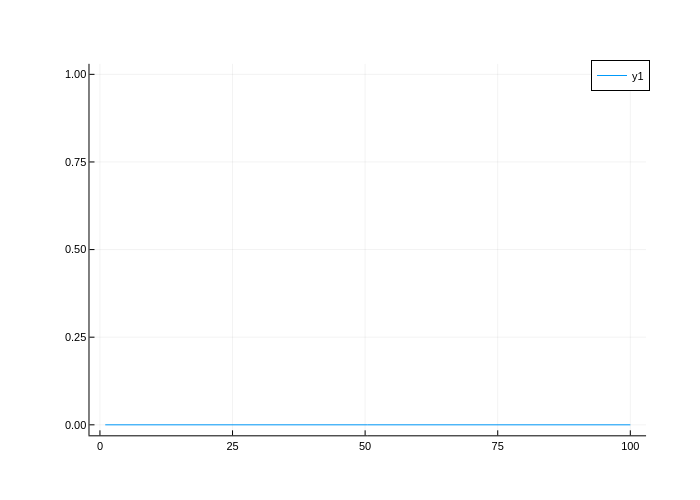

In [374]:
lossHistory = []
@showprogress for epoch in 1:100
    Flux.train!(loss, parameters, data, optimiser)
    currentLoss = loss(xTrain, yTrain)
    push!(lossHistory, currentLoss)
end
plot(lossHistory)

50.00584339696144

170×302 Matrix{Float32}:
 0.0       0.112536  0.112536  0.112536  …  0.0       0.0       0.112536
 0.112536  0.112536  0.38517   0.368415     0.0       0.112536  0.0
 0.112536  0.136659  0.0       0.112536     0.112536  0.0       0.341057
 0.112536  0.112536  0.112536  0.496668     0.112536  0.112536  0.0
 0.397223  0.112536  0.112536  0.383821     0.112536  0.0       0.112536
 0.112536  0.112536  0.0       0.112536  …  0.112536  0.0       0.0
 0.0       0.112536  0.0       0.0          0.0       0.112536  0.112536
 0.112536  0.0       0.0       0.112536     0.112536  0.0       0.112536
 0.0       0.112536  0.112536  0.112536     0.112536  0.112536  0.112536
 0.112536  0.112536  0.112536  0.112536     0.0       0.112536  0.112536
 ⋮                                       ⋱            ⋮         
 0.0       0.112536  0.0       0.112536     0.112536  0.0       0.0
 0.0       0.112536  0.18544   0.0          0.112536  0.384938  0.0
 0.112536  0.0       0.0       0.0          0.112536  0.0  

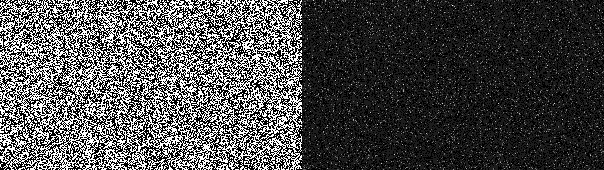

In [375]:
reshapeX, reshapeY = 170, 302
result = model(xTrain |> gpu) |> cpu
maxRes = maximum(result)
minRes = minimum(result)
rawAns = (result .- minRes) ./ (maxRes - minRes)
displayImg = reshape(rawAns, reshapeX, reshapeY)
exReshape = Float32.(reshape(yTrain, reshapeX, reshapeY)) |> cpu

roundRawAns = round.(rawAns)
points = 0
for i in 1:size(roundRawAns, 2)
    if roundRawAns[i] == yTest[i]
        points = points + 1
    end
end
accuracy = (points/size(roundRawAns, 2)) * 100

display(accuracy)
display(displayImg)

img1 = Gray.(exReshape)
img2 = Gray.(displayImg)
mosaicview(img1, img2; nrow = 1)